<a href="https://colab.research.google.com/github/Sabelz/Master_Thesis_Alexander/blob/main/GPs/ConcreteGPs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gaussian Processes on the Concrete dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Master_Thesis_Alexander
!git config --global user.email "alexander.sabelstrom.1040@student.uu.se"
!git config --global user.name "Sabelz"

Mounted at /content/drive
/content/drive/MyDrive/Master_Thesis_Alexander


# Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
!pip install gpytorch
import gpytorch
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler

%matplotlib inline
%load_ext autoreload
%autoreload 2
%run "datasets/concrete.ipynb" # Run the Concrete notebook
%run "utils/models.ipynb" # Run the models notebook
%run "utils/functions.ipynb" # Run the functions notebook

# Set the seed for NumPy's random number generator
np.random.seed(0)

torch.manual_seed(0)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.6/175.6 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 kB 4.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manyl

# Prepare The Data

In [3]:
concrete_data = df_Concrete # df_Concrete is defined in ../datasets/concrete.ipynb
# Concrete compressive strength(last feature) is the regression problem
x_concrete, y_concrete = concrete_data.iloc[:, :-1].to_numpy() , concrete_data.iloc[:, -1].to_numpy()

x_train_concrete, x_test_concrete, y_train_concrete, y_test_concrete = train_test_split(x_concrete,
                                                                                        y_concrete,
                                                                                        test_size=0.2,
                                                                                        random_state=666)
# Transform into tensors
x_train_concrete, x_test_concrete, y_train_concrete, y_test_concrete = (
torch.from_numpy(x_train_concrete).float(), torch.from_numpy(x_test_concrete).float(),
torch.from_numpy(y_train_concrete).float(), torch.from_numpy(y_test_concrete).float())

# Standardized data
scaler = StandardScaler()
x_train_concrete_standardized = torch.from_numpy(scaler.fit_transform(x_train_concrete)).float()
# Use the same scaler that was used on training data
x_test_concrete_standardized = torch.from_numpy(scaler.transform(x_test_concrete)).float()

if torch.cuda.is_available():
    x_train_concrete, y_train_concrete, x_test_concrete, y_test_concrete, x_train_concrete_standardized, x_test_concrete_standardized = (
    x_train_concrete.cuda(), y_train_concrete.cuda(), x_test_concrete.cuda(), y_test_concrete.cuda(),
    x_train_concrete_standardized.cuda(), x_test_concrete_standardized.cuda())

# Train data into batches
#train_dataset_concrete = TensorDataset(x_train_concrete, y_train_concrete)
#train_loader_concrete = DataLoader(train_dataset_concrete, batch_size=500, shuffle=True)

# Test data into batches
#test_dataset_concrete = TensorDataset(x_test_concrete, y_test_concrete)
#test_loader_concrete = DataLoader(test_dataset_concrete, batch_size=500, shuffle=False)

# Standardized batches
# Train data into batches
#train_dataset_concrete_standardized = TensorDataset(x_train_concrete_standardized, y_train_concrete)
#train_loader_concrete_standardized = DataLoader(train_dataset_concrete_standardized, batch_size=500, shuffle=True)

# Test data into batches
#test_dataset_concrete_standardized = TensorDataset(x_test_concrete_standardized, y_test_concrete)
#test_loader_concrete_standardized = DataLoader(test_dataset_concrete_standardized, batch_size=500, shuffle=False)

# Define the KISS-GP Model

In [4]:
KISSGP_likelihood_concrete = gpytorch.likelihoods.GaussianLikelihood() # Likelihood
KISSGP_mean_concrete = gpytorch.means.ConstantMean() # Mean
KISSGP_kernel_concrete = gpytorch.kernels.RBFKernel() # Kernel
KISSGP_model_concrete = KISSGP_NDim(x_train_concrete,
                                 y_train_concrete,
                                 KISSGP_likelihood_concrete,
                                 KISSGP_mean_concrete,
                                 KISSGP_kernel_concrete) # KISSGP defined in utils/Models.ipynb
KISSGP_model_concrete = KISSGP_model_concrete.to(device) # Move model to device.

# One with standardized features
KISSGP_likelihood_concrete_standardized = gpytorch.likelihoods.GaussianLikelihood() # Likelihood
KISSGP_mean_concrete_standardized = gpytorch.means.ConstantMean() # Mean
KISSGP_kernel_concrete_standardized = gpytorch.kernels.RBFKernel() # Kernel
KISSGP_model_concrete_standardized = KISSGP_NDim(x_train_concrete_standardized,
                                              y_train_concrete,
                                              KISSGP_likelihood_concrete_standardized,
                                              KISSGP_mean_concrete_standardized,
                                              KISSGP_kernel_concrete_standardized) # KISSGP defined in utils/Models.ipynb
KISSGP_model_concrete_standardized = KISSGP_model_concrete_standardized.to(device) # Move model to device.

# Train and Evaluate the KISS-GP Model

/usr/local/lib/python3.10/dist-packages/linear_operator/utils/sparse.py:51: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if nonzero_indices.storage():
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/sparse.py:66: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:621.)
  res = cls(index_tensor, value_tensor, interp_size)


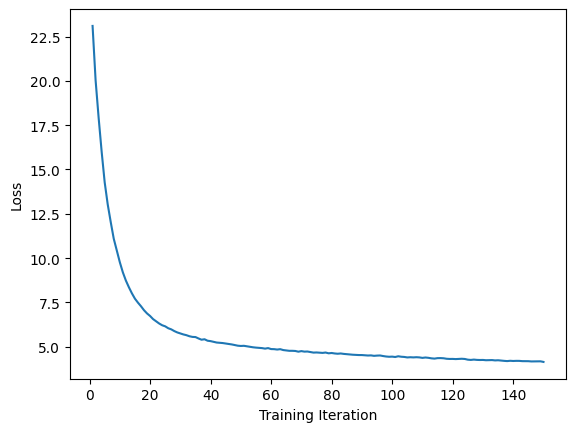

In [5]:
train_time_KISSGP_concrete = train(KISSGP_model_concrete,
                          KISSGP_likelihood_concrete,
                          x_train_concrete,
                          y_train_concrete,
                          training_iter= 150) # train is defined in utils/functions.ipynb


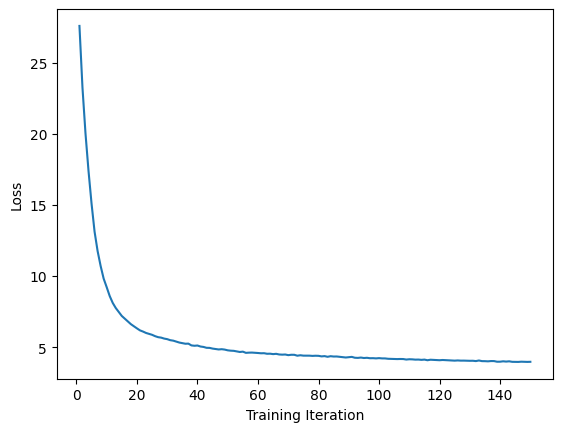

In [6]:
# Standardized version
train_time_KISSGP_concrete_standardized = train(KISSGP_model_concrete_standardized,
                                       KISSGP_likelihood_concrete_standardized,
                                       x_train_concrete_standardized,
                                       y_train_concrete,
                                       training_iter= 150) # train is defined in utils/functions.ipynb

In [7]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
  predictions_KISSGP_concrete = predict(KISSGP_model_concrete, KISSGP_likelihood_concrete,
                                     x_test_concrete) # predict is defined in utils/functions.ipynb
  RMSE_KISSGP_concrete, NLPD_KISSGP_concrete, PICP_KISSGP_concrete, MPIW_KISSGP_concrete = error_metrics(
      x_test_concrete,
      y_test_concrete,
      predictions_KISSGP_concrete.mean,
      predictions_KISSGP_concrete.variance)# error_metrics defined in utils/functions.ipynb


  # Standardized version
  predictions_KISSGP_concrete_standardized = predict(KISSGP_model_concrete_standardized, KISSGP_likelihood_concrete_standardized,
                                                  x_test_concrete_standardized) # predict is defined in utils/functions.ipynb

  RMSE_KISSGP_concrete_standardized, NLPD_KISSGP_concrete_standardized, PICP_KISSGP_concrete_standardized, MPIW_KISSGP_concrete_standardized = error_metrics(
      x_test_concrete_standardized,
      y_test_concrete,
      predictions_KISSGP_concrete_standardized.mean,
      predictions_KISSGP_concrete_standardized.variance)# error_metrics defined in utils/functions.ipynb


  print("RMSE KISS-GP: ",RMSE_KISSGP_concrete)
  print("NLPD KISS-GP: ",NLPD_KISSGP_concrete)
  print("PICP KISS-GP: ",PICP_KISSGP_concrete)
  print("MPIW KISS-GP: ",MPIW_KISSGP_concrete)
  print("Time KISS-GP: ", train_time_KISSGP_concrete)

  print("RMSE KISS-GP Standardized: ",RMSE_KISSGP_concrete_standardized)
  print("NLPD KISS-GP Standardized: ",NLPD_KISSGP_concrete_standardized)
  print("PICP KISS-GP Standardized: ",PICP_KISSGP_concrete_standardized)
  print("MPIW KISS-GP Standardized: ",MPIW_KISSGP_concrete_standardized)
  print("Time KISS-GP Standardized: ", train_time_KISSGP_concrete_standardized)

RMSE KISS-GP:  7.2586975
NLPD KISS-GP:  4.484224319458008
PICP KISS-GP:  0.6893203883495146
MPIW KISS-GP:  13.578409
Time KISS-GP:  40.35024952888489
RMSE KISS-GP Standardized:  5.0941596
NLPD KISS-GP Standardized:  3.1752920150756836
PICP KISS-GP Standardized:  0.8786407766990292
MPIW KISS-GP Standardized:  17.162785
Time KISS-GP Standardized:  18.226234436035156


# Variational Distribution Model

In [8]:
variational_likelihood_concrete = gpytorch.likelihoods.GaussianLikelihood()
variational_mean_concrete = gpytorch.means.ConstantMean()
variational_kernel_concrete = gpytorch.kernels.RBFKernel()
n_inducing_points = int(len(x_train_concrete)/10)
# Generate a tensor of random indices
indices = torch.randperm(x_train_concrete.size(0))
# Select N random rows
inducing_points = x_train_concrete[indices][:n_inducing_points]
variational_model_concrete = variationalGP(variational_likelihood_concrete,
                                        variational_mean_concrete,
                                        variational_kernel_concrete,
                                        inducing_points) # InducingGP defined in utils/models.ipynb
variational_model_concrete = variational_model_concrete.to(device) # Move model to device, defined in utils/models.ipynb

# Standardized version
variational_likelihood_concrete_standardized = gpytorch.likelihoods.GaussianLikelihood()
variational_mean_concrete_standardized = gpytorch.means.ConstantMean()
variational_kernel_concrete_standardized = gpytorch.kernels.RBFKernel()
n_inducing_points = int(len(x_train_concrete_standardized)/10)
# Generate a tensor of random indices
indices = torch.randperm(x_train_concrete_standardized.size(0))
# Select N random rows
inducing_points_standardized = x_train_concrete_standardized[indices][:n_inducing_points]
variational_model_concrete_standardized = variationalGP(variational_likelihood_concrete_standardized,
                                               variational_mean_concrete_standardized,
                                               variational_kernel_concrete_standardized,
                                               inducing_points_standardized) # InducingGP defined in utils/models.ipynb
variational_model_concrete_standardized = variational_model_concrete_standardized.to(device) # Move model to device, defined in utils/models.ipynb

# Train and Evaluate Variational Model

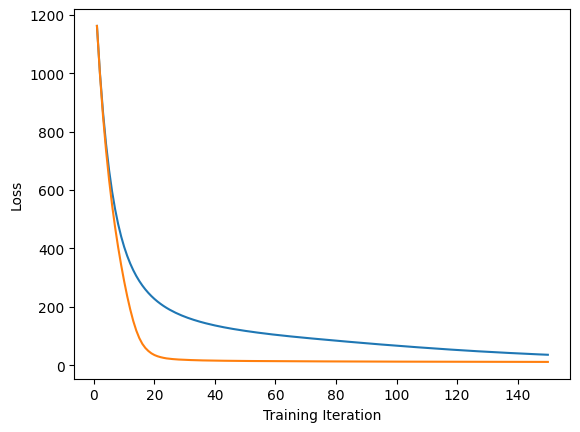

In [9]:
# Use train_loader_concrete
train_time_variational_concrete = train_ELBO(variational_model_concrete,
                                 variational_likelihood_concrete,
                                 x_train_concrete,
                                 y_train_concrete,
                                 training_iter= 150) # train is defined in utils/functions.ipynb

# Standardized version, train_loader_concrete_standardized
train_time_variational_concrete_standardized = train_ELBO(variational_model_concrete_standardized,
                                              variational_likelihood_concrete_standardized,
                                              x_train_concrete_standardized,
                                              y_train_concrete,
                                              training_iter= 150) # train is defined in utils/functions.ipynb

In [10]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
  # predict is defined in utils/functions.ipynb
  predictions_variational_concrete = predict(variational_model_concrete, variational_likelihood_concrete, x_test_concrete)

  RMSE_variational_concrete, NLPD_variational_concrete, PICP_variational_concrete, MPIW_variational_concrete = error_metrics(
      x_test_concrete,
      y_test_concrete,
      predictions_variational_concrete.mean,
      predictions_variational_concrete.variance)# error_metrics defined in utils/functions.ipynb
  print("RMSE variational Model: ",RMSE_variational_concrete)
  print("NLPD variational Model: ",NLPD_variational_concrete)
  print("PICP variational Model: ",PICP_variational_concrete)
  print("MPIW variational Model: ",MPIW_variational_concrete)
  print("Time variational Model: ", train_time_variational_concrete)

  # Standardized version
  predictions_variational_concrete_standardized = predict(variational_model_concrete_standardized,
                                       variational_likelihood_concrete_standardized,
                                       x_test_concrete_standardized)

  RMSE_variational_concrete_standardized, NLPD_variational_concrete_standardized, PICP_variational_concrete_standardized, MPIW_variational_concrete_standardized = error_metrics(
      x_test_concrete_standardized,
      y_test_concrete,
      predictions_variational_concrete_standardized.mean,
      predictions_variational_concrete_standardized.variance)# error_metrics defined in utils/functions.ipynb
  print("RMSE variational Model Standardized: ",RMSE_variational_concrete_standardized)
  print("NLPD variational Model Standardized: ",NLPD_variational_concrete_standardized)
  print("PICP variational Model Standardized: ",PICP_variational_concrete_standardized)
  print("MPIW variational Model Standardized: ",MPIW_variational_concrete_standardized)
  print("Time variational Model Standardized: ", train_time_variational_concrete_standardized)

RMSE variational Model:  18.533287
NLPD variational Model:  10.209244728088379
PICP variational Model:  0.5097087378640777
MPIW variational Model:  17.18639
Time variational Model:  2.6374950408935547
RMSE variational Model Standardized:  7.175514
NLPD variational Model Standardized:  6.923578262329102
PICP variational Model Standardized:  0.4854368932038835
MPIW variational Model Standardized:  8.715335
Time variational Model Standardized:  1.9565482139587402


# Inducing Points Model

In [11]:
inducing_likelihood_concrete = gpytorch.likelihoods.GaussianLikelihood() # Likelihood
inducing_mean_concrete = gpytorch.means.ConstantMean() # Mean
inducing_kernel_concrete = gpytorch.kernels.RBFKernel() # Kernel
# Choose random inital inducing points
# Generate a tensor of random indices
indices = torch.randperm(x_train_concrete.size(0))
# Select N random rows
inducing_points_amount = int(len(x_train_concrete)/10)
inducing_points = x_train_concrete[indices][:inducing_points_amount].double()
inducing_model_concrete = inducingGP(x_train_concrete.double(),
                                 y_train_concrete.double(),
                                 inducing_likelihood_concrete,
                                 inducing_mean_concrete,
                                 inducing_kernel_concrete,
                                 inducing_points) # inducingGP defined in utils/Models.ipynb

inducing_model_concrete = inducing_model_concrete.to(device) # Move model to device.

# One with standardized features
inducing_likelihood_concrete_standardized = gpytorch.likelihoods.GaussianLikelihood() # Likelihood
inducing_mean_concrete_standardized = gpytorch.means.ConstantMean() # Mean
inducing_kernel_concrete_standardized = gpytorch.kernels.RBFKernel() # Kernel
# Generate a tensor of random indices
indices = torch.randperm(x_train_concrete_standardized.size(0))
# Select N random rows
inducing_points_standardized = x_train_concrete_standardized[indices][:inducing_points_amount]
inducing_model_concrete_standardized = inducingGP(x_train_concrete_standardized,
                                              y_train_concrete,
                                              inducing_likelihood_concrete_standardized,
                                              inducing_mean_concrete_standardized,
                                              inducing_kernel_concrete_standardized,
                                              inducing_points_standardized) # inducingGP defined in utils/Models.ipynb

inducing_model_concrete_standardized = inducing_model_concrete_standardized.to(device) # Move model to device.

# Train and Evaluate Inducing Model

/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


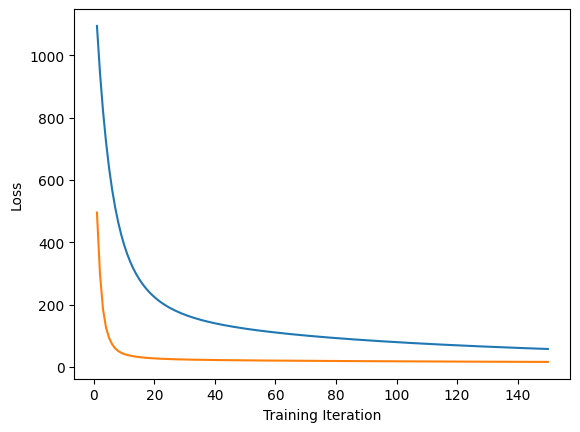

In [12]:
train_time_inducing_concrete = train(inducing_model_concrete,
                          inducing_likelihood_concrete,
                          x_train_concrete.double(),
                          y_train_concrete.double(),
                          training_iter= 150) # train is defined in utils/functions.ipynb
# Standardized version
train_time_inducing_concrete_standardized = train(inducing_model_concrete_standardized,
                                       inducing_likelihood_concrete_standardized,
                                       x_train_concrete_standardized,
                                       y_train_concrete,
                                       training_iter= 150) # train is defined in utils/functions.ipynb

In [13]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
  predictions_inducing_concrete = predict(inducing_model_concrete, inducing_likelihood_concrete,
                                     x_test_concrete) # predict is defined in utils/functions.ipynb
  RMSE_inducing_concrete, NLPD_inducing_concrete, PICP_inducing_concrete, MPIW_inducing_concrete = error_metrics(
      x_test_concrete,
      y_test_concrete,
      predictions_inducing_concrete.mean,
      predictions_inducing_concrete.variance)# error_metrics defined in utils/functions.ipynb


  # Standardized version
  predictions_inducing_concrete_standardized = predict(inducing_model_concrete_standardized, inducing_likelihood_concrete_standardized,
                                                  x_test_concrete_standardized) # predict is defined in utils/functions.ipynb

  RMSE_inducing_concrete_standardized, NLPD_inducing_concrete_standardized, PICP_inducing_concrete_standardized, MPIW_inducing_concrete_standardized = error_metrics(
      x_test_concrete_standardized,
      y_test_concrete,
      predictions_inducing_concrete_standardized.mean,
      predictions_inducing_concrete_standardized.variance)# error_metrics defined in utils/functions.ipynb


  print("RMSE inducing: ",RMSE_inducing_concrete)
  print("NLPD inducing: ",NLPD_inducing_concrete)
  print("PICP inducing: ",PICP_inducing_concrete)
  print("MPIW inducing: ",MPIW_inducing_concrete)
  print("Time inducing: ", train_time_inducing_concrete)

  print("RMSE inducing Standardized: ",RMSE_inducing_concrete_standardized)
  print("NLPD inducing Standardized: ",NLPD_inducing_concrete_standardized)
  print("PICP inducing Standardized: ",PICP_inducing_concrete_standardized)
  print("MPIW inducing Standardized: ",MPIW_inducing_concrete_standardized)
  print("Time inducing Standardized: ", train_time_inducing_concrete_standardized)

RMSE inducing:  24.873574565781272
NLPD inducing:  41.095066732844884
PICP inducing:  0.18446601941747573
MPIW inducing:  11.017098284827437
Time inducing:  7.495299577713013
RMSE inducing Standardized:  7.8601494
NLPD inducing Standardized:  8.503929138183594
PICP inducing Standardized:  0.4320388349514563
MPIW inducing Standardized:  8.304831
Time inducing Standardized:  1.665895700454712


# Exact Gaussian Process Model

In [14]:
exact_likelihood_concrete = gpytorch.likelihoods.GaussianLikelihood() # Likelihood
exact_mean_concrete = gpytorch.means.ConstantMean() # Mean
exact_kernel_concrete = gpytorch.kernels.MaternKernel() # Kernel
exact_model_concrete = exactGP(x_train_concrete,
                             y_train_concrete,
                             exact_likelihood_concrete,
                             exact_mean_concrete,
                             exact_kernel_concrete) # exactGP defined in utils/Models.ipynb
exact_model_concrete = exact_model_concrete.to(device) # Move model to device, defined in utils/models.ipynb


# Standardized version

exact_likelihood_concrete_standardized = gpytorch.likelihoods.GaussianLikelihood() # Likelihood
exact_mean_concrete_standardized = gpytorch.means.ConstantMean() # Mean
exact_kernel_concrete_standardized = gpytorch.kernels.MaternKernel() # Kernel
exact_model_concrete_standardized = exactGP(x_train_concrete_standardized,
                             y_train_concrete,
                             exact_likelihood_concrete_standardized,
                             exact_mean_concrete_standardized,
                             exact_kernel_concrete_standardized) # exactGP defined in utils/Models.ipynb
exact_model_concrete_standardized = exact_model_concrete_standardized.to(device) # Move model to device, defined in utils/models.ipynb

# Train The Model

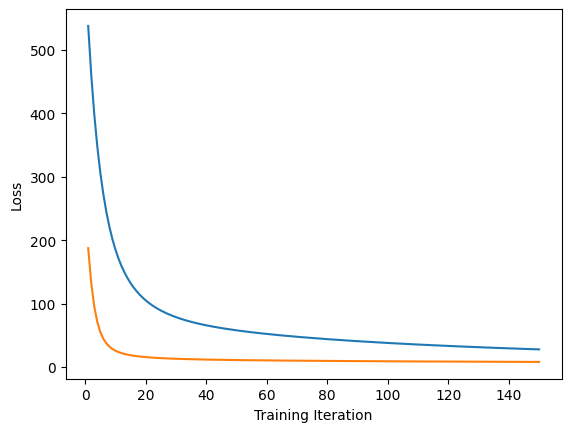

In [15]:
train_time_exact_concrete = train(exact_model_concrete,
                                 exact_likelihood_concrete,
                                 x_train_concrete,
                                 y_train_concrete,
                                 training_iter= 150) # train is defined in utils/functions.ipynb


train_time_exact_concrete_standardized = train(exact_model_concrete_standardized,
                                 exact_likelihood_concrete_standardized,
                                 x_train_concrete_standardized,
                                 y_train_concrete,
                                 training_iter= 150) # train is defined in utils/functions.ipynb

# Evaluate Exact-GP

In [16]:

# Evaluate
with torch.no_grad(), gpytorch.settings.fast_pred_var():
  predictions_exact_concrete = predict(exact_model_concrete, exact_likelihood_concrete,
                                     x_test_concrete) # predict is defined in utils/functions.ipynb
  RMSE_exact_concrete, NLPD_exact_concrete, PICP_exact_concrete, MPIW_exact_concrete = error_metrics(
      x_test_concrete,
      y_test_concrete,
      predictions_exact_concrete.mean,
      predictions_exact_concrete.variance)# error_metrics defined in utils/functions.ipynb



# Standardized

# Evaluate
with torch.no_grad(), gpytorch.settings.fast_pred_var():
  predictions_exact_concrete_standardized = predict(exact_model_concrete_standardized, exact_likelihood_concrete_standardized,
                                     x_test_concrete_standardized) # predict is defined in utils/functions.ipynb
  RMSE_exact_concrete_standardized, NLPD_exact_concrete_standardized, PICP_exact_concrete_standardized, MPIW_exact_concrete_standardized = error_metrics(
      x_test_concrete_standardized,
      y_test_concrete,
      predictions_exact_concrete_standardized.mean,
      predictions_exact_concrete_standardized.variance)# error_metrics defined in utils/functions.ipynb


  print("RMSE Exact-GP: ",RMSE_exact_concrete)
  print("NLPD Exact-GP: ",NLPD_exact_concrete)
  print("PICP Exact-GP: ",PICP_exact_concrete)
  print("MPIW Exact-GP: ",MPIW_exact_concrete)
  print("Time Exact-GP: ", train_time_exact_concrete)

  print("")

  print("RMSE Exact-GP Standardized: ",RMSE_exact_concrete_standardized)
  print("NLPD Exact-GP Standardized: ",NLPD_exact_concrete_standardized)
  print("PICP Exact-GP Standardized: ",PICP_exact_concrete_standardized)
  print("MPIW Exact-GP Standardized: ",MPIW_exact_concrete_standardized)
  print("Time Exact-GP Standardized: ", train_time_exact_concrete_standardized)

RMSE Exact-GP:  19.317936
NLPD Exact-GP:  16.15451431274414
PICP Exact-GP:  0.3106796116504854
MPIW Exact-GP:  14.243579
Time Exact-GP:  26.061143398284912

RMSE Exact-GP Standardized:  6.8295746
NLPD Exact-GP Standardized:  4.9484357833862305
PICP Exact-GP Standardized:  0.5776699029126213
MPIW Exact-GP Standardized:  10.796621
Time Exact-GP Standardized:  4.989196300506592


# Display Results

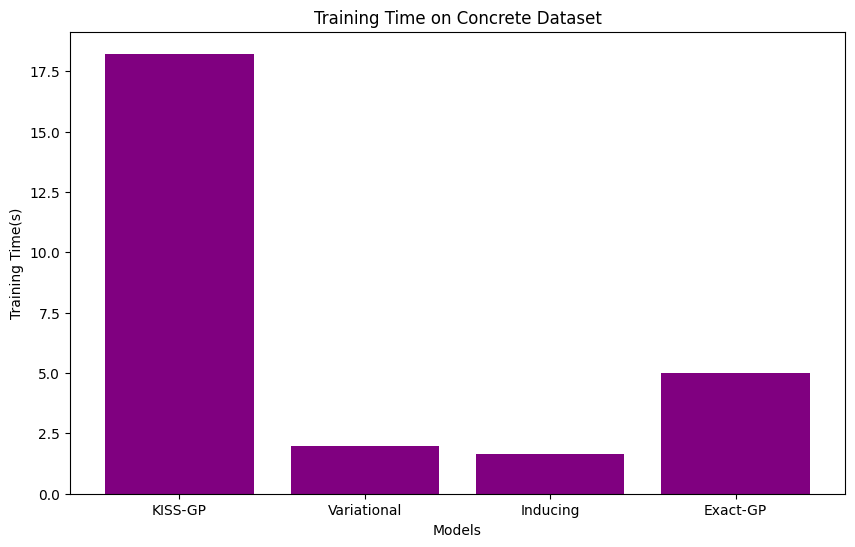

In [17]:
# Training times
models = ["KISS-GP", "Variational", "Inducing", "Exact-GP"]
times_concrete = [train_time_KISSGP_concrete_standardized, train_time_variational_concrete_standardized, train_time_inducing_concrete_standardized, train_time_exact_concrete_standardized]
plot_bar(models, times_concrete, "Training Time on Concrete Dataset", "Models", "Training Time(s)") # plot_bar defined in utils/function.ipynb

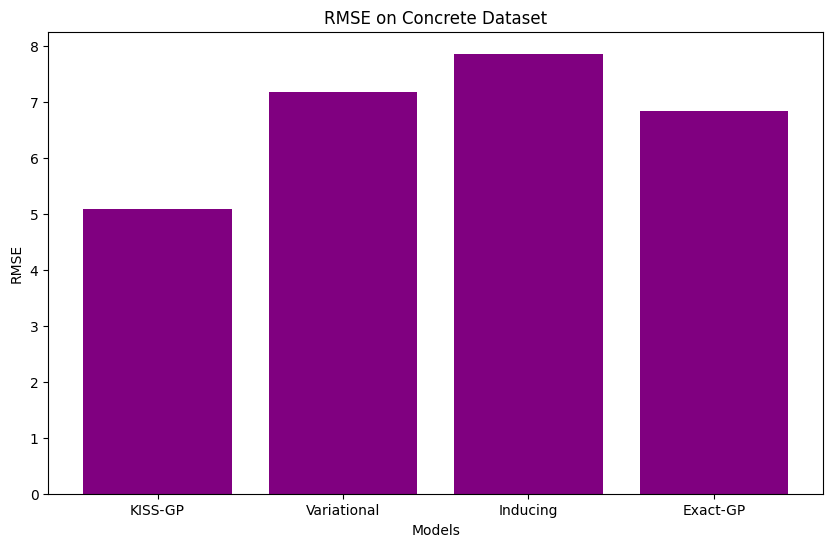

In [18]:
# RMSE
models = ["KISS-GP", "Variational", "Inducing", "Exact-GP"]
RMSE_concrete = [RMSE_KISSGP_concrete_standardized, RMSE_variational_concrete_standardized, RMSE_inducing_concrete_standardized,RMSE_exact_concrete_standardized]
plot_bar(models, RMSE_concrete, "RMSE on Concrete Dataset", "Models", "RMSE") # plot_bar defined in utils/function.ipynb

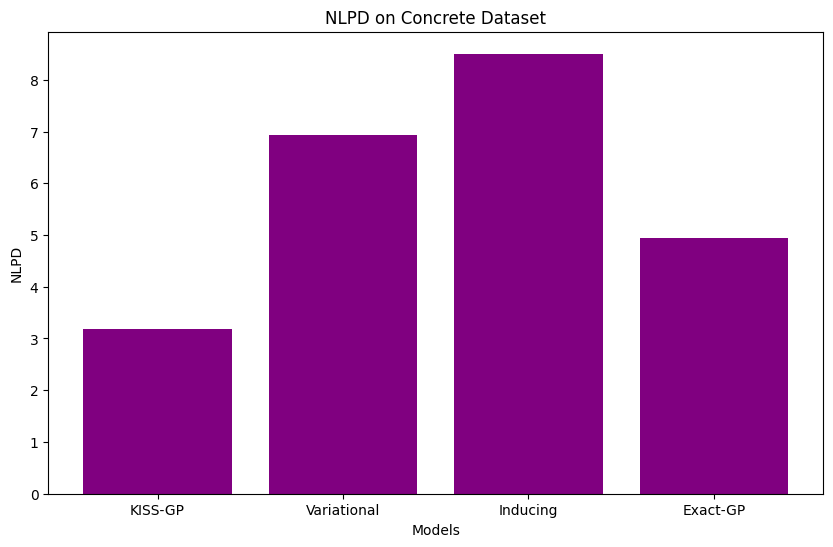

In [19]:
# NLPD
models = ["KISS-GP", "Variational", "Inducing", "Exact-GP"]
NLPD_concrete = [NLPD_KISSGP_concrete_standardized, NLPD_variational_concrete_standardized, NLPD_inducing_concrete_standardized,NLPD_exact_concrete_standardized]
plot_bar(models, NLPD_concrete, "NLPD on Concrete Dataset", "Models", "NLPD") # plot_bar defined in utils/function.ipynb

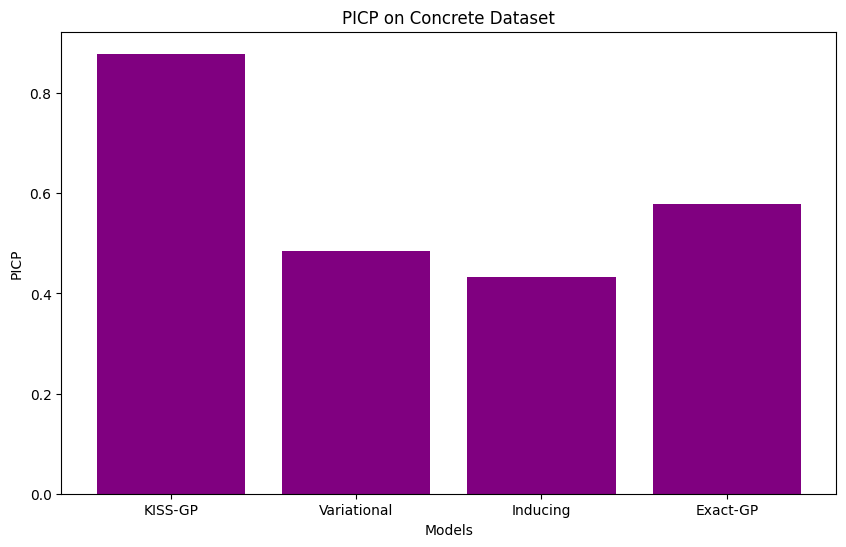

In [20]:
# PICP
models = ["KISS-GP", "Variational", "Inducing", "Exact-GP"]
PICP_concrete = [PICP_KISSGP_concrete_standardized, PICP_variational_concrete_standardized, PICP_inducing_concrete_standardized,PICP_exact_concrete_standardized]
plot_bar(models, PICP_concrete, "PICP on Concrete Dataset", "Models", "PICP") # plot_bar defined in utils/function.ipynb

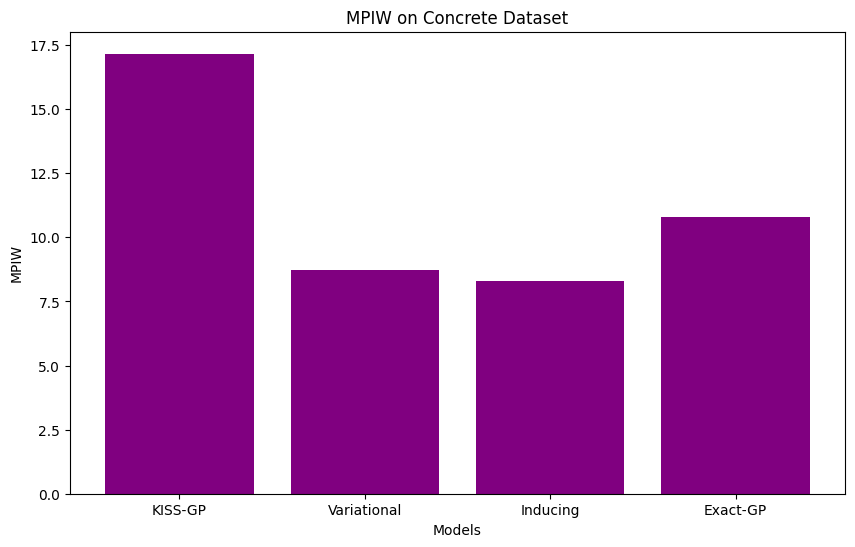

In [21]:
# MPIW
models = ["KISS-GP", "Variational", "Inducing", "Exact-GP"]
MPIW_concrete = [MPIW_KISSGP_concrete_standardized, MPIW_variational_concrete_standardized, MPIW_inducing_concrete_standardized, MPIW_exact_concrete_standardized]
plot_bar(models, MPIW_concrete, "MPIW on Concrete Dataset", "Models", "MPIW") # plot_bar defined in utils/function.ipynb

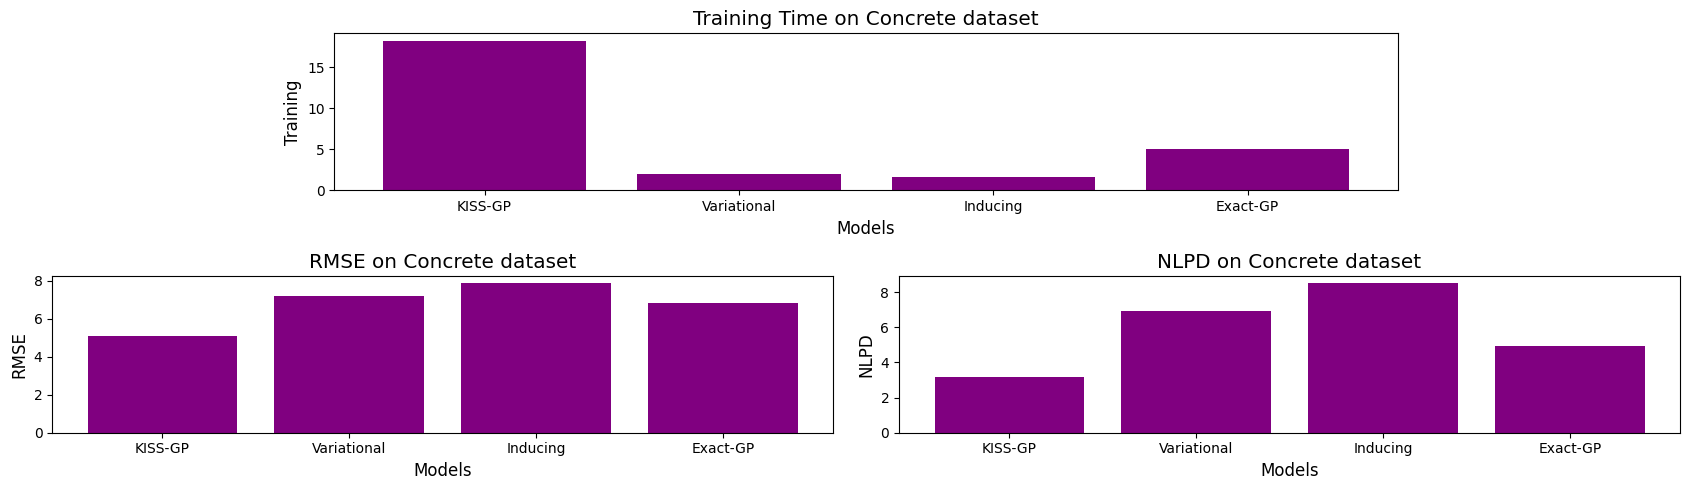

In [22]:
from matplotlib.gridspec import GridSpec

gs = GridSpec(2, 6)  # 2 rows, 6 columns

fig = plt.figure(figsize=(17, 5))

# Create subplots
ax1 = fig.add_subplot(gs[0, 1:5])
ax2 = fig.add_subplot(gs[1, 0:3])
ax3 = fig.add_subplot(gs[1, 3:6])


axes = [ax1, ax2, ax3]  # List of axes
data = [times_concrete, RMSE_concrete, NLPD_concrete]
titles = ["Training Time on Concrete dataset", "RMSE on Concrete dataset", "NLPD on Concrete dataset"]

# Plot data
for i, ax in enumerate(axes):
    ax.bar(models, data[i], color='purple')
    ax.set_title(titles[i], size = "x-large")
    ax.set_xlabel("Models", size = "large")
    ax.set_ylabel(titles[i].split(" ")[0], size = "large")

plt.tight_layout()
plt.savefig("metrics_concrete1.pdf")
plt.show()

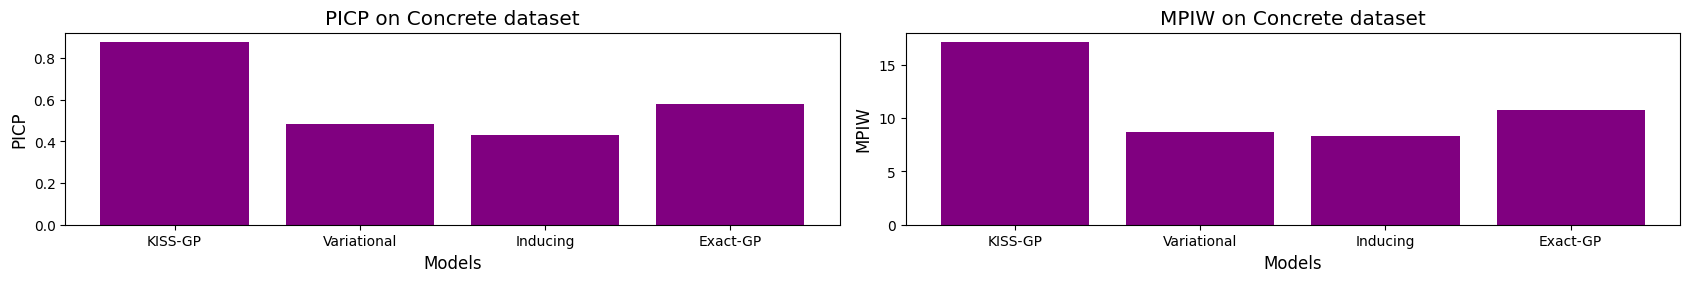

In [23]:
from matplotlib.gridspec import GridSpec

gs = GridSpec(2, 6)  # 2 rows, 6 columns

fig = plt.figure(figsize=(17, 5))

# Create subplots
ax1 = fig.add_subplot(gs[0, 0:3])
ax2 = fig.add_subplot(gs[0, 3:6])


axes = [ax1, ax2]  # List of axes
data = [PICP_concrete, MPIW_concrete]
titles = ["PICP on Concrete dataset", "MPIW on Concrete dataset"]

# Plot data
for i, ax in enumerate(axes):
    ax.bar(models, data[i], color='purple')
    ax.set_title(titles[i], size = "x-large")
    ax.set_xlabel("Models", size = "large")
    ax.set_ylabel(titles[i].split(" ")[0], size = "large")

plt.tight_layout()
plt.savefig("metrics_concrete2.pdf")
plt.show()

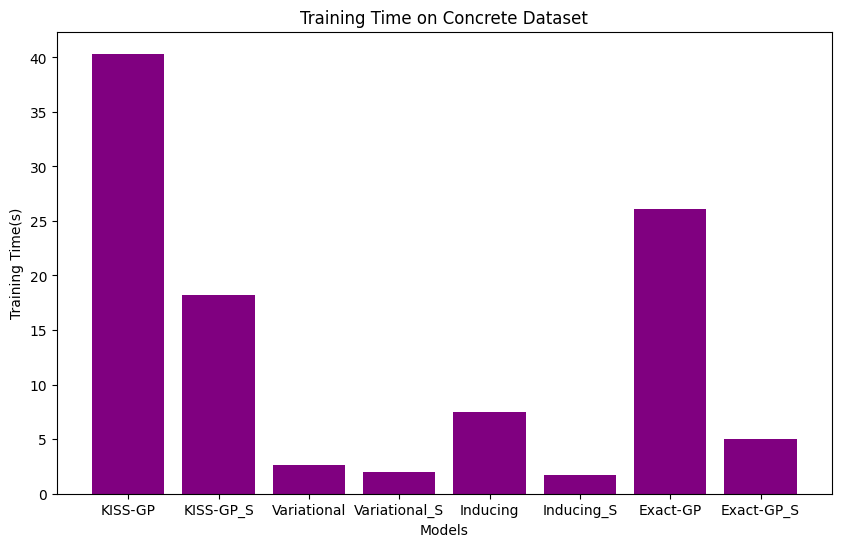

In [24]:
# Standardized or not?
# Training Time
models_compare = ["KISS-GP", "KISS-GP_S", "Variational", "Variational_S",  "Inducing", "Inducing_S", "Exact-GP", "Exact-GP_S"]
time_compare = [train_time_KISSGP_concrete, train_time_KISSGP_concrete_standardized,
                train_time_variational_concrete, train_time_variational_concrete_standardized,
                train_time_inducing_concrete, train_time_inducing_concrete_standardized,
                train_time_exact_concrete, train_time_exact_concrete_standardized]
plot_bar(models_compare, time_compare, "Training Time on Concrete Dataset", "Models", "Training Time(s)") # plot_bar defined in utils/function.ipynb

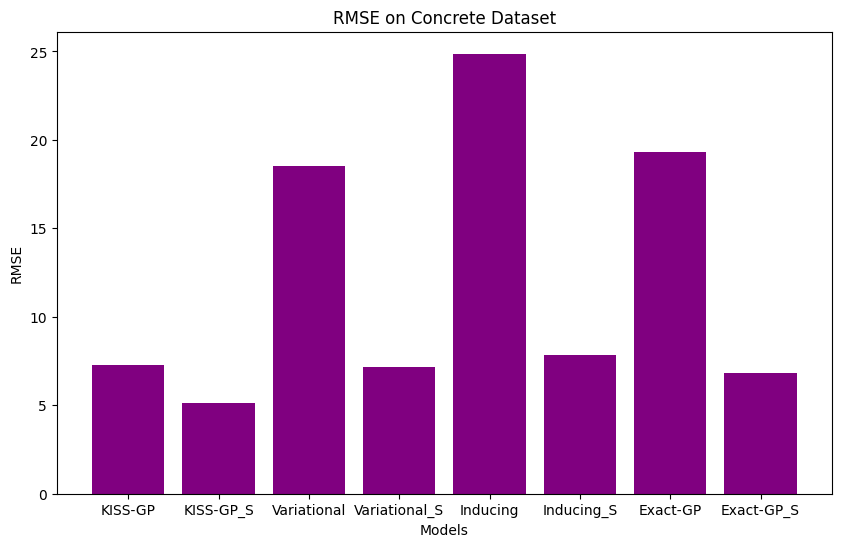

In [25]:
# Standardized or not?
# RMSE
models_compare = ["KISS-GP", "KISS-GP_S", "Variational", "Variational_S",  "Inducing", "Inducing_S", "Exact-GP", "Exact-GP_S"]
RMSE_compare = [RMSE_KISSGP_concrete, RMSE_KISSGP_concrete_standardized,
                RMSE_variational_concrete, RMSE_variational_concrete_standardized,
                RMSE_inducing_concrete, RMSE_inducing_concrete_standardized,
                RMSE_exact_concrete,RMSE_exact_concrete_standardized]
plot_bar(models_compare, RMSE_compare, "RMSE on Concrete Dataset", "Models", "RMSE") # plot_bar defined in utils/function.ipynb

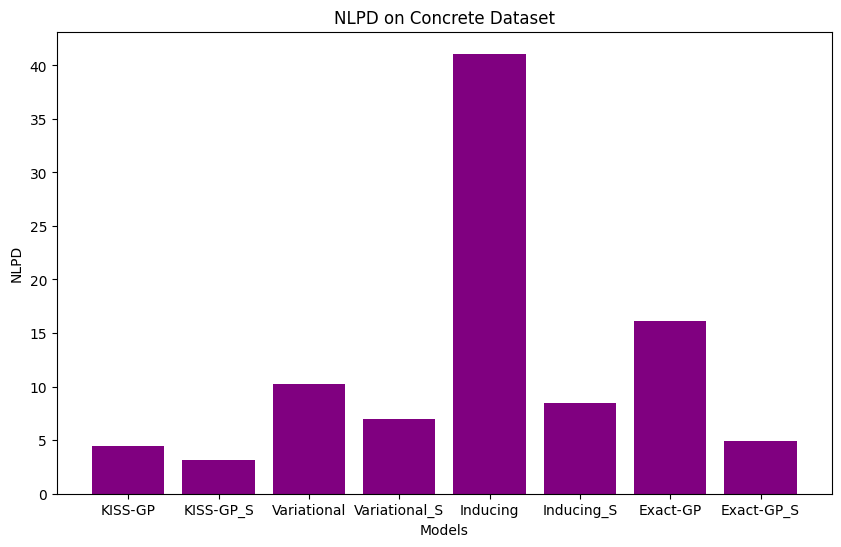

In [26]:
# Standardized or not?
# NLPD
models_compare = ["KISS-GP", "KISS-GP_S", "Variational", "Variational_S",  "Inducing", "Inducing_S", "Exact-GP", "Exact-GP_S"]
NLPD_compare = [NLPD_KISSGP_concrete, NLPD_KISSGP_concrete_standardized,
                NLPD_variational_concrete, NLPD_variational_concrete_standardized,
                NLPD_inducing_concrete, NLPD_inducing_concrete_standardized,
                NLPD_exact_concrete, NLPD_exact_concrete_standardized]
plot_bar(models_compare, NLPD_compare, "NLPD on Concrete Dataset", "Models", "NLPD") # plot_bar defined in utils/function.ipynb

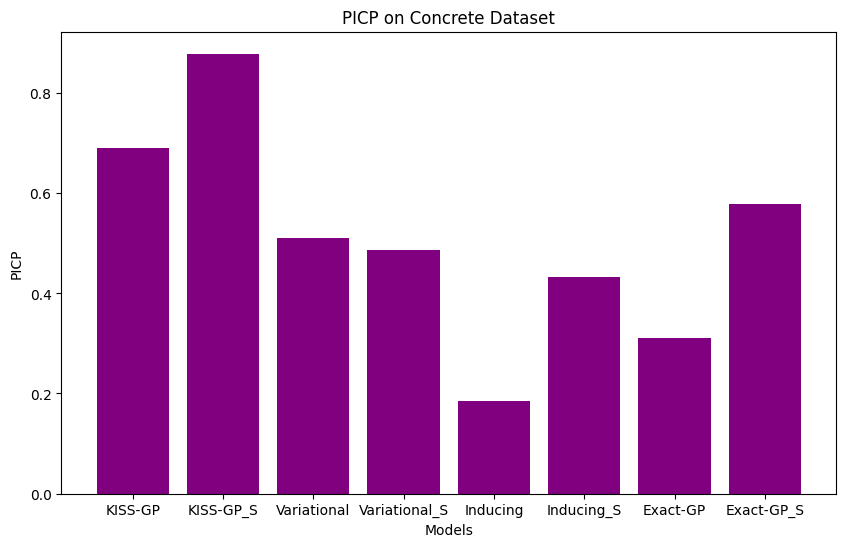

In [27]:
# Standardized or not?
# PICP
models_compare = ["KISS-GP", "KISS-GP_S", "Variational", "Variational_S",  "Inducing", "Inducing_S", "Exact-GP", "Exact-GP_S"]
PICP_compare = [PICP_KISSGP_concrete, PICP_KISSGP_concrete_standardized,
                PICP_variational_concrete, PICP_variational_concrete_standardized,
                PICP_inducing_concrete, PICP_inducing_concrete_standardized,
                PICP_exact_concrete, PICP_exact_concrete_standardized]
plot_bar(models_compare, PICP_compare, "PICP on Concrete Dataset", "Models", "PICP") # plot_bar defined in utils/function.ipynb

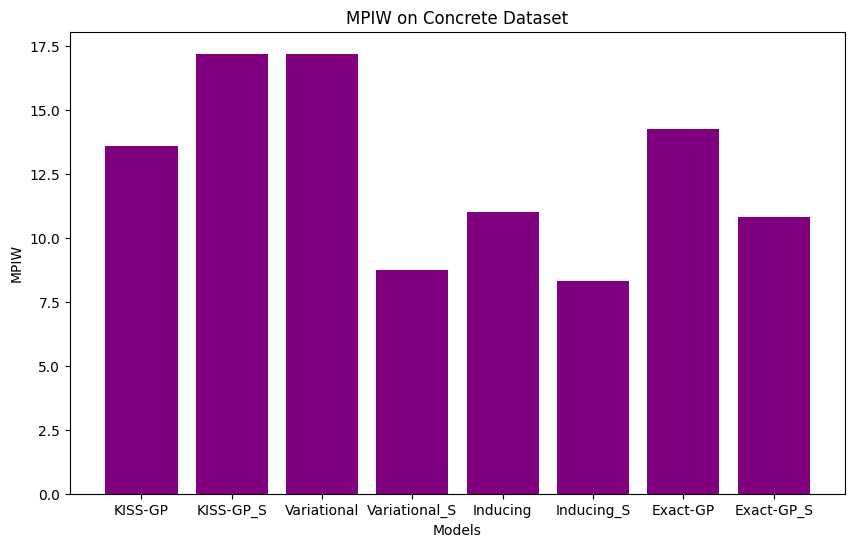

In [28]:
# Standardized or not?
# MPIW
models_compare = ["KISS-GP", "KISS-GP_S", "Variational", "Variational_S",  "Inducing", "Inducing_S", "Exact-GP", "Exact-GP_S"]
MPIW_compare = [MPIW_KISSGP_concrete, MPIW_KISSGP_concrete_standardized,
                MPIW_variational_concrete, MPIW_variational_concrete_standardized,
                MPIW_inducing_concrete, MPIW_inducing_concrete_standardized,
                MPIW_exact_concrete, MPIW_exact_concrete_standardized]
plot_bar(models_compare, MPIW_compare, "MPIW on Concrete Dataset", "Models", "MPIW") # plot_bar defined in utils/function.ipynb

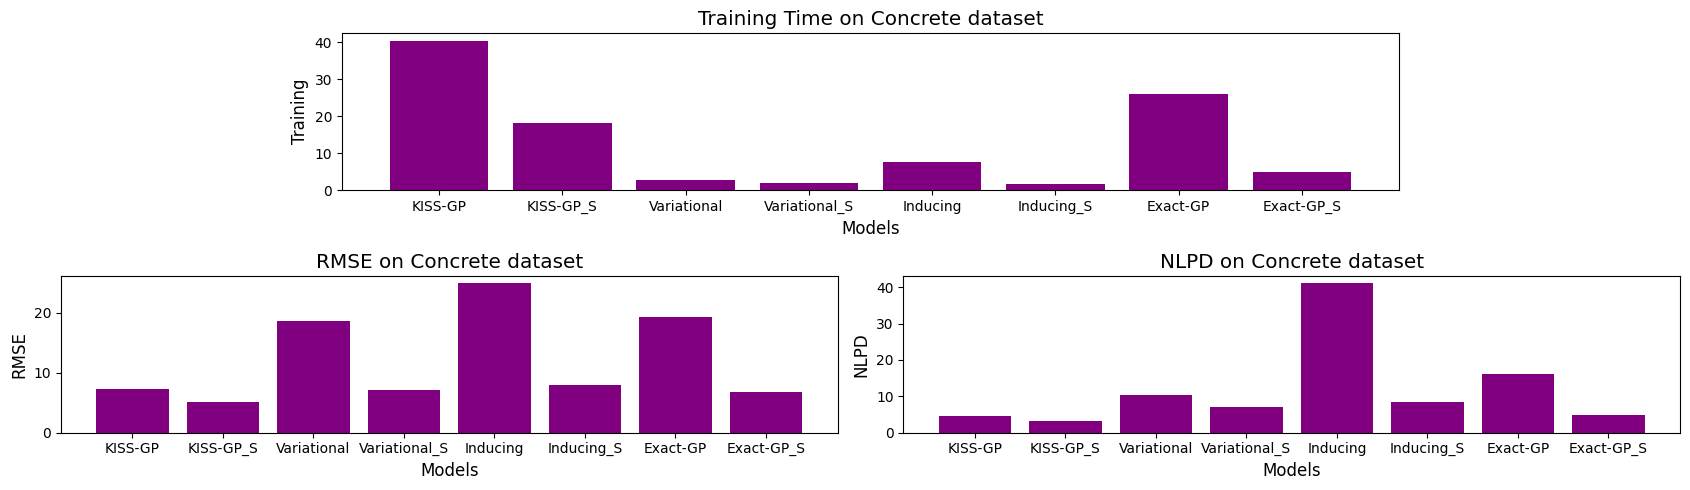

In [29]:
from matplotlib.gridspec import GridSpec

gs = GridSpec(2, 6)  # 2 rows, 6 columns

fig = plt.figure(figsize=(17, 5))
# Create subplots
ax1 = fig.add_subplot(gs[0, 1:5])
ax2 = fig.add_subplot(gs[1, 0:3])
ax3 = fig.add_subplot(gs[1, 3:6])

axes = [ax1, ax2, ax3]  # List of axes


data = [time_compare, RMSE_compare, NLPD_compare]
titles = ["Training Time on Concrete dataset", "RMSE on Concrete dataset", "NLPD on Concrete dataset"]

# Plot data
for i, ax in enumerate(axes):
    ax.bar(models_compare, data[i], color='purple')
    ax.set_title(titles[i], size = "x-large")
    ax.set_xlabel("Models", size = "large")
    ax.set_ylabel(titles[i].split(" ")[0], size = "large")

plt.tight_layout()
plt.savefig("metrics_concrete_compare1.pdf")
plt.show()

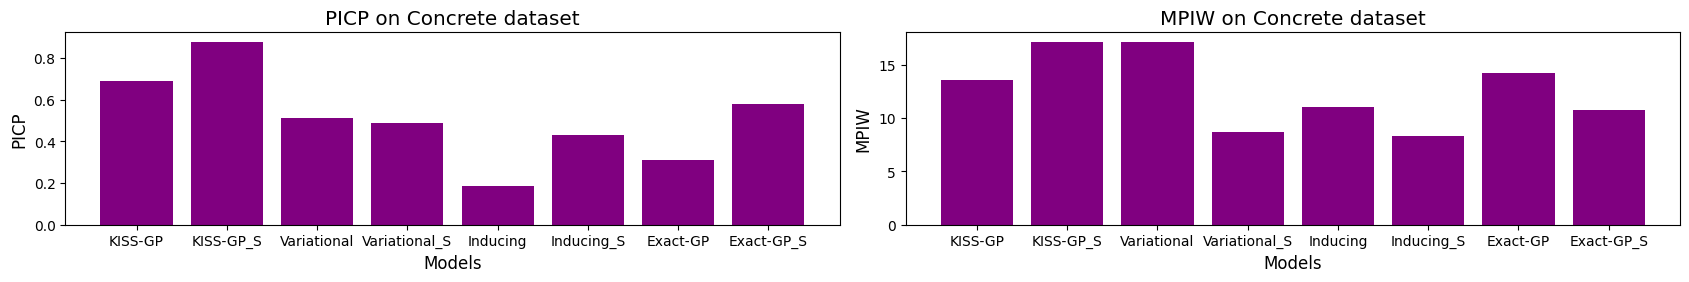

In [30]:
from matplotlib.gridspec import GridSpec

gs = GridSpec(2, 6)  # 2 rows, 6 columns

fig = plt.figure(figsize=(17, 5))
# Create subplots
ax1 = fig.add_subplot(gs[0, 0:3])  # Spans columns 1-4
ax2 = fig.add_subplot(gs[0, 3:6])  # Spans columns 0-2


axes = [ax1, ax2]  # List of axes


data = [PICP_compare, MPIW_compare]
titles = ["PICP on Concrete dataset", "MPIW on Concrete dataset"]

# Plot data
for i, ax in enumerate(axes):
    ax.bar(models_compare, data[i], color='purple')
    ax.set_title(titles[i], size = "x-large")
    ax.set_xlabel("Models", size = "large")
    ax.set_ylabel(titles[i].split(" ")[0], size = "large")

plt.tight_layout()
plt.savefig("metrics_concrete_compare2.pdf")
plt.show()